In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk

from nltk.corpus import stopwords

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import accuracy_score, zero_one_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import warnings

In [ ]:
#upload the csv files
uploaded = files.upload()

Saving test.csv to test.csv


In [ ]:
uploaded2 = files.upload()

Saving train.csv to train.csv


In [ ]:
uploaded3 = files.upload()

Saving test_labels.csv to test_labels.csv


In [ ]:
train_data = pd.read_csv('train.csv')

# Extract features and labels for train data
X_train = train_data[['id', 'comment_text']]  # Features are in the 'comment_text' column
y_train = train_data[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]  # Labels for toxicity classes

# Load test data and test labels
test_data = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

# Filter out rows with -1 in labels for test data
valid_test_labels = test_labels[(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]
y_test = valid_test_labels[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


X_test = test_data[['id','comment_text']]

# Get indices of valid_test_labels
valid_indices = valid_test_labels.index

# Filter X_test using valid indices
X_test_filtered = X_test.loc[valid_indices]

# Concatenate train and filtered test labels
df = pd.concat([y_train, y_test], ignore_index=True)

(63978, 2)


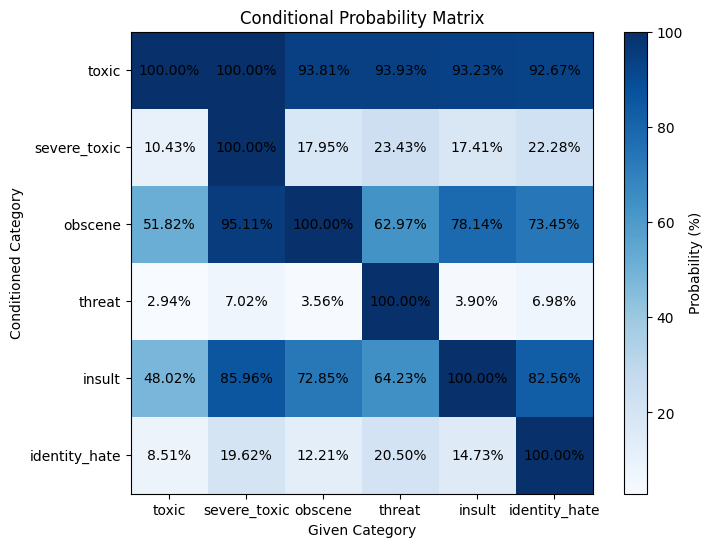

In [ ]:
#make a contingency matrix visual
df = y_train
# Assuming 'labels' is a DataFrame containing the multi-label toxic comment data
# Extracting the label columns

label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = df[label_columns].values  # Assuming df is the DataFrame containing the data

# Calculate the total number of instances
total_instances = len(labels)

# Calculate the conditional probability matrix
conditional_prob_matrix = np.zeros((len(label_columns), len(label_columns)))

for i, col_i in enumerate(label_columns):
    for j, col_j in enumerate(label_columns):
        both_true = sum((labels[:, i] == 1) & (labels[:, j] == 1))
        col_j_true = sum((labels[:, j] == 1))

        if col_j_true != 0:  # Avoid division by zero
            conditional_prob_matrix[i, j] = (both_true / col_j_true) * 100

# Plotting the conditional probability matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conditional_prob_matrix, cmap='Blues', interpolation='nearest')

# Displaying values in each cell
for i in range(conditional_prob_matrix.shape[0]):
    for j in range(conditional_prob_matrix.shape[1]):
        plt.text(j, i, f"{conditional_prob_matrix[i, j]:.2f}%", ha='center', va='center', color='black')

plt.xlabel('Given Category')
plt.ylabel('Conditioned Category')
plt.title('Conditional Probability Matrix')
plt.colorbar(label='Probability (%)')
plt.xticks(np.arange(len(label_columns)), label_columns)
plt.yticks(np.arange(len(label_columns)), label_columns)
plt.show()


[15294  1595  8449   478  7877  1405]


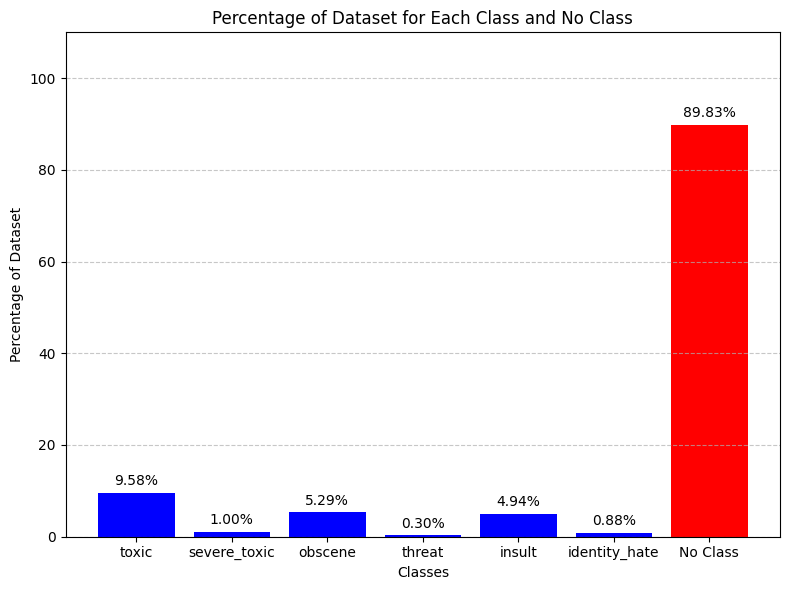

In [ ]:
# create visual graph of class distribution
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = df[label_columns].values  # Assuming df is the DataFrame containing the data

# Calculate the total number of instances
total_instances = len(df)

# Calculate the number of instances for each class
class_instances = labels.sum(axis=0)

# Calculate the instances that do not belong to any class
no_class_instances = sum((labels.sum(axis=1)) == 0)
print(class_instances)
# Calculate the percentage of instances for each class

class_percentages = (class_instances / total_instances) * 100

# Calculate the percentage of instances that do not belong to any class
no_class_percentage = (no_class_instances / total_instances) * 100

# Plotting the percentages
plt.figure(figsize=(8, 6))
plt.bar(label_columns, class_percentages, color='blue')
plt.bar('No Class', no_class_percentage, color='red')

# Displaying percentages on top of the bars
for i, percentage in enumerate(list(class_percentages) + [no_class_percentage]):
    plt.text(i, percentage + 1, f"{percentage:.2f}%", ha='center', va='bottom', fontsize=10)

plt.xlabel('Classes')
plt.ylabel('Percentage of Dataset')
plt.title('Percentage of Dataset for Each Class and No Class')
plt.ylim(0, 110)  # Set y-axis limit for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#remove stop words

nltk.download('stopwords')  # Download stopwords data if not already downloaded

# Assuming you've loaded the data as mentioned and named 'data'

# Load English stop words from NLTK
stop_words = set(stopwords.words('english'))

# Preprocess training data
X_train['comment_text'] = X_train['comment_text'].apply(
    lambda text: ' '.join([word for word in str(text).split() if word.lower() not in stop_words])
)

# Preprocess testing data
X_test['comment_text'] = X_test['comment_text'].apply(
    lambda text: ' '.join([word for word in str(text).split() if word.lower() not in stop_words])
)

#create new tfidf vectors to use as datum

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['comment_text'])
X_test_tfidf = tfidf_vectorizer.fit_transform(X_test['comment_text'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-17-45c3a3772c98>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['comment_text'] = X_train['comment_text'].apply(


In [ ]:
binary_classifiers = {}
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


# Train a binary classifier for each label
for label in label_columns:
    # Create a binary label for the specific category
    y_binary = y_train[label]

    # Initialize Logistic Regression model
    model = LogisticRegression(max_iter=1000)  # You can modify parameters as needed

    # Train the binary classifier
    model.fit(X_train_tfidf, y_binary)

    # Save the trained model in the dictionary
    binary_classifiers[label] = model

In [ ]:
#printing for debugging
print(y_test[label].shape)
print(type(y_test[label]))
print(X_test_filtered.shape)

(63978,)
<class 'pandas.core.series.Series'>
(63978, 2)


In [ ]:
for label in label_columns:
    y_binary_test = y_test[[label]]
    y_pred = binary_classifiers[label].predict(X_test_tfidf)
    error_rate = sum(y_pred != y_binary_test) / len(y_binary_test)
    print(f"Error rate for '{label}': {error_rate:.4f}")


ValueError: ignored

In [ ]:
# Initialize an empty array to store predictions for each classifier
all_predictions = []

# Iterate through each classifier
for label, model in binary_classifiers.items():
    # Predict using the corresponding binary classifier
    y_binary_test = y_test[label]  # Extract the specific label from test data

    y_pred = model.predict(X_test_tfidf)

    # Append the predictions to the array
    all_predictions.append(y_pred)
    error_rate = sum(y_pred != y_binary_test) / len(y_binary_test)

    print(f"Error rate for '{label}': {error_rate:.4f}")
# Convert the list of arrays into a single NumPy array
all_predictions = np.array(all_predictions).T  # Transpose to have predictions for each datum as a row


ValueError: ignored

In [ ]:
'''# Get the category names from the columns of y_test
categories = y_test.drop(columns='id').columns.tolist()

# Get predictions on the test data
predictions = multi_target_classifier.predict(tfidf_vectorizer.transform(X_test['comment_text']))

# Calculate F1-score for each category
f1_scores = []
for i, category in enumerate(categories):
    f1 = f1_score(y_test[category], predictions[:, i],average=None)
    f1_scores.append(f1)




# Calculate the average F1-score across all categories
average_f1_score = sum(f1_scores) / len(f1_scores)

# Print the F1-scores for each category and the average F1-score
for i, category in enumerate(categories):
    print(f"F1-score for {category}: {f1_scores[i]}")

print(f"Average F1-score: {average_f1_score}")
'''
'''
F1-score for toxic:         [0.59828455 0.27357689]
F1-score for severe_toxic:  [0.58857477 0.14646465]
F1-score for obscene:       [0.59681319 0.25706231]
F1-score for threat:        [0.58809633 0.20047733]
F1-score for insult:        [0.58917662 0.25272395]
F1-score for identity_hate: [0.58634464 0.20841180]
Average F1-score:           [0.59121502 0.22311949]
'''

F1-score for toxic: [0.         0.59828455 0.27357689]
F1-score for severe_toxic: [0.         0.58857477 0.14646465]
F1-score for obscene: [0.         0.59681319 0.25706231]
F1-score for threat: [0.         0.58809633 0.20047733]
F1-score for insult: [0.         0.58917662 0.25272395]
F1-score for identity_hate: [0.         0.58634464 0.2084118 ]
Average F1-score: [0.         0.59121502 0.22311949]
